# External Integration

## General

[Nino-hist](https://nino-hist.site) is a systematic tool based on [boost-histogram](https://boost-histogram.readthedocs.io/en/latest). The HEP analysis is a complicated process and relies on many other [(Sckit-HEP) tools](https://scikit-hep.org/). Thus, it's intuitive for [Nino-hist](https://nino-hist.site) to support the integration of these external packages and modules. In this part, we will demonstrate how [Nino-hist](https://nino-hist.site) works and its interaction with other [(Sckit-HEP) tools](https://scikit-hep.org/).

A brief workflow of HEP analysis is as below:

![](https://tva1.sinaimg.cn/large/00831rSTly1gd40ndja44j30lk058q3d.jpg)

## De/serialization

If we want to analysis data, what do we need to do first? To load the data files, of course! How do we do it? It denpends on the file, of course! 

### pickle Integration

We could use [pickle](https://docs.python.org/3/library/pickle.html) to deal with it like this:

In [1]:
import hist
import pickle
from pathlib import Path

h1 = hist.Hist(hist.axis.Regular(2, -1, 1, name='h_1'))
h2 = h1.copy()
h2.name = 'h_2'

h1.fill(-0.5)
h2.fill(0.5)

# Arithmetic operators
h3 = h1 + h2
h2.name = 'h_3'
h4 = h3 * 2
h2.name = 'h_4'

print(f"{h4[0]}, {h4[1]}")

h4_saved = Path("pickle_file.pkl")

# Now save the histogram
with h4_saved.open("wb") as f:
    pickle.dump(h4, f, protocol=-1)

# And load
with h4_saved.open("rb") as f:
    h5 = pickle.load(f)

assert h4 == h5
print("Succeeded in pickling a histogram!")

# Delete the file to keep things tidy
# h4_saved.unlink()

2.0, 2.0
Succeeded in pickling a histogram!


### aghast Integration

Though [pickle](https://docs.python.org/3/library/pickle.html) is capable for serialization and deserialization, we sometimes need to use ROOT files for loading and saving data in HEP analysis. Initially, we expect to use [aghast](https://github.com/scikit-hep/aghast) for [Nino-hist](https://nino-hist.site) to interactive with ROOT files. While it's not pure Pythonic and not installable on PyPI, currently. Thus, here we first demonstrate the availability of [aghast](https://github.com/scikit-hep/aghast) and then show how to save and load our histograms by [aghast](https://github.com/scikit-hep/aghast)'s underlying [uproot](https://github.com/scikit-hep/uproot). [aghast](https://github.com/scikit-hep/aghast) is a histogramming library that does not fill histograms and does not plot them. Its role is behind the scenes, to provide better communication between histogramming libraries.

As we need to make [Nino-hist](https://nino-hist.site) available to communicate with [aghast](https://github.com/scikit-hep/aghast), that is, to change [aghast](https://github.com/scikit-hep/aghast)'s histograms to [aghast](https://github.com/scikit-hep/aghast)'s histograms.

In [2]:
import aghast
import numpy as np
import matplotlib.pyplot as plt

h = hist.Hist(hist.axis.Regular(50, -3, 3, name='x'))
h.fill(np.random.normal(size=1_000_000))
ghastly_hist = aghast.from_numpy(h.to_numpy())
ghastly_hist.dump()

Histogram(
  axis=[
    Axis(binning=RegularBinning(num=50, interval=RealInterval(low=-3.0, high=2.9999999999999996)))
  ],
  counts=
    WeightedCounts(
      sumw=
        InterpretedInlineFloat64Buffer(
          buffer=
              [  633.   841.  1273.  1817.  2324.  3077.  4077.  5304.  6775.  8417.
               10582. 12991. 15554. 18490. 21941. 25120. 28839. 31609. 35316. 38458.
               41635. 43466. 45603. 46843. 47655. 47754. 47388. 45594. 43733. 41031.
               38711. 35442. 32205. 28463. 24793. 21814. 18531. 15621. 12792. 10405.
                8297.  6747.  5341.  4026.  3103.  2294.  1776.  1233.   893.   627.])))


See, it works! We are looking forward to [aghast](https://github.com/scikit-hep/aghast)'s update, and we can use the `ghastly_hist` for better use.

I am sure it will be a shortcut for file serialization and deserialization.

### uproot Integration

Now that [aghast](https://github.com/scikit-hep/aghast) need the more detailed development to support serialization and deserialization for our [Nino-hist](https://nino-hist.site), we have to use [uproot](https://github.com/scikit-hep/uproot) to demonstrate how can we save and load histograms in [Nino-hist](https://nino-hist.site) by ROOT files.

[uproot](https://github.com/scikit-hep/uproot) is the most classical ROOT I/O in Python. It is a reader and a writer of the [ROOT file format](https://root.cern/) using only Python and Numpy. Unlike the standard C++ ROOT implementation, uproot is only an I/O library, primarily intended to stream data into machine learning libraries in Python. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT. Instead, it uses Numpy to cast blocks of data from the ROOT file as Numpy arrays.

The first thing we need to do is to create [Nino-hist](https://nino-hist.site)'s histograms as normal.

In [3]:
import hist
import uproot
import numpy as np
import matplotlib.pyplot as plt

file = uproot.recreate("demo_root_file.root")
h = hist.Hist(hist.axis.Regular(20, -3, 3, name='x'))
h.fill(np.random.normal(size=1_000))

w, data = h.to_numpy()

Here, we use a little tricks. First, we convert the [Nino-hist](https://nino-hist.site)'s histogram to a Numpy histogram. And then write the histogram as well as a title to the `demo_root_file.root`. We load the demo to another file, printing the title, showing the histogram.

In [4]:
file['title'] = 'A histogram'
file['h'] = np.histogram(data[:-1], bins=data, weights=w)
file2 = uproot.open("demo_root_file.root")
print(file2['title'])
file2['h'].show()

A histogram
                 0                                                         134.4
                 +-------------------------------------------------------------+
[-inf, -3)   0   |                                                             |
[-3, -2.7)   3   |*                                                            |
[-2.7, -2.4) 6   |***                                                          |
[-2.4, -2.1) 7   |***                                                          |
[-2.1, -1.8) 19  |*********                                                    |
[-1.8, -1.5) 31  |**************                                               |
[-1.5, -1.2) 51  |***********************                                      |
[-1.2, -0.9) 57  |**************************                                   |
[-0.9, -0.6) 97  |********************************************                 |
[-0.6, -0.3) 104 |***********************************************              |
[-0.3, 0)    117

Note that [uproot](https://github.com/scikit-hep/uproot) is a pretty large package which supports many functionalities. Here, we just demonstate how to save and load ROOT files. You can go to the origin to see more information.

## Histogram

### Nino-hist

[Nino-hist](https://nino-hist.site) acts as the histogramming part, i.e., "Data" to "Histogram", in HEP analysis workflow. It is based on [boost-histogram](https://boost-histogram.readthedocs.io/en/latest), meaning that you can do whatever you like in [boost-histogram](https://boost-histogram.readthedocs.io/en/latest) with histograms of [Nino-hist](https://nino-hist.site). Let's see some examples.

First, we will re-use the 2D-density histogram example of [boost-histogram](https://boost-histogram.readthedocs.io/en/latest).

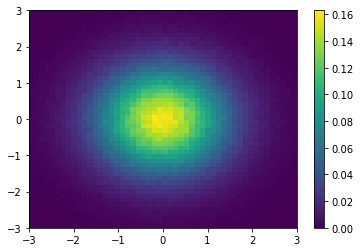

In [5]:
import hist
import numpy as np
import matplotlib.pyplot as plt

# Make a 2D histogram
h = hist.Hist(hist.axis.Regular(50, -3, 3, name='x'), hist.axis.Regular(50, -3, 3, name='y'))

# Fill with Gaussian random values
h.fill(np.random.normal(size=1_000_000), np.random.normal(size=1_000_000))

# Compute the areas of each bin
areas = np.prod(h.axes.widths, axis=0)

# Compute the density
density = h.view() / h.sum() / areas

# Get the edges
X, Y = h.axes.edges

# Make the plot
fig, ax = plt.subplots()
mesh = ax.pcolormesh(X.T, Y.T, density.T)
fig.colorbar(mesh)
plt.show()

Nice! This is good, because this means that you can migrate your [boost-histogram](https://boost-histogram.readthedocs.io/en/latest) codes to [Nino-hist](https://nino-hist.site) directly.

Another example:

In [6]:
import hist
import boost_histogram as bh

# Make 1-d histogram with 5 logarithmic bins from 1e0 to 1e5
h = hist.Hist(
    hist.axis.Regular(5, 1e0, 1e5, name="x", transform=bh.axis.transform.log),
    storage=bh.storage.Weight(),
)

# Fill histogram with numbers
x = (2e0, 2e1, 2e2, 2e3, 2e4)

# Doing this several times so the variance is more interesting
h.fill(x, weight=1)
h.fill(x, weight=1)
h.fill(x, weight=1)
h.fill(x, weight=1)

# Iterate over bins and access bin counter
for idx, (lower, upper) in enumerate(h.axes[0]):
    val = h[idx]
    print(val)
    print(f"bin {idx} in [{lower:g}, {upper:g}): {val.value} +/- {val.variance**.5}")

WeightedSum(value=4, variance=4)
bin 0 in [1, 10): 4.0 +/- 2.0
WeightedSum(value=4, variance=4)
bin 1 in [10, 100): 4.0 +/- 2.0
WeightedSum(value=4, variance=4)
bin 2 in [100, 1000): 4.0 +/- 2.0
WeightedSum(value=4, variance=4)
bin 3 in [1000, 10000): 4.0 +/- 2.0
WeightedSum(value=4, variance=4)
bin 4 in [10000, 100000): 4.0 +/- 2.0


We haven't define `Storage` and `transform` for [Nino-hist](https://nino-hist.site) yet, so you cannot directly use them in our package, but [Nino-hist](https://nino-hist.site)'s compatibility with [boost-histogram](https://boost-histogram.readthedocs.io/en/latest) is good, so you can use whatever you need by citing [boost-histogram](https://boost-histogram.readthedocs.io/en/latest)'s corresponding modules.

To sum up, [Nino-hist](https://nino-hist.site) acts as the core part in HEP analysis workflow, allowing us to histogram data. This is valuable for "Data" to "Histogram" in HEP analyse workflow!

## Analysis

Here we are going to show how some [(Sckit-HEP)](https://scikit-hep.org/) analysis tools are integrated to our package.

### iminuit Integration

[iminuit](https://iminuit.readthedocs.io/en/latest/index.html) is most commonly used for likelihood fits of models to data, and to get model parameter error estimates from likelihood profile analysis. It's a numerical minimizer and error calculator. You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) is similar to other minimizers, like those in `scipy.optimize`.

Let's use an example to see how can [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) fits the data in [Nino-hist](https://nino-hist.site).

Hist(Regular(20, 0, 10, underflow=False, overflow=False, metadata={'name': 'iminuit', 'title': None}), storage=Double()) # Sum: 844.3786162013363

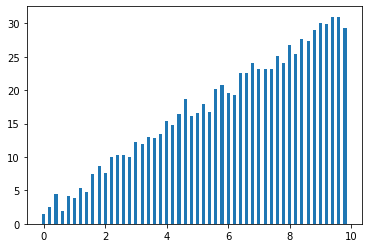

In [7]:
import hist
import numpy as np
import matplotlib.pyplot as plt

k = 3.
b = 2.
data_x = np.arange(0, 10, .2)
offset = np.random.normal(size=50)
data_y = k * data_x + b + offset

plt.bar(data_x, data_y, width=0.1)

h = hist.Hist(
    hist.axis.Regular(20, 0, 10, name='iminuit', underflow=False, overflow=False)
)

h.fill(data_x, weight=data_y)

By this way, we create and fill a histogram with the linear distribution, i.e., the weight of each bin is the multiple of its index. Of course you can also use a histogram loading by serialization. Back to the point, it's a linear distribution, and we want to use a fitter to get its slope `k` and intercept `b`.

First, we need to access the data (the weight of histogram) and define the error func to be minimized.

In [8]:
y, x = h.to_numpy()

def least_squares_np(par):  # par is a numpy array here 
    mu = np.polyval(par, data_x)  # for par = (a, b) this is a line
    yvar = 0.01
    return np.sum((data_y - mu) ** 2 / yvar)

Then, we will initialized the parameters in an array (two elements in this linear case), the step size, and the error definition (`errordef = 0.5` for negative log-likelihood functions, `errordef = 1` for least-squares functions). You are able to see the minuit initial states use `get_param_states()`.

In [9]:
from iminuit import Minuit

m = Minuit.from_array_func(least_squares_np, (5, 5), error=(0.1, 0.1), errordef=1, name=('k', 'b'))
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | k    |   5.00    |   0.10    |            |            |         |         |       |
| 1 | b    |   5.00    |   0.10    |            |            |         |         |       |
------------------------------------------------------------------------------------------

And it's time for fitting! It's pretty handy in [iminuit](https://iminuit.readthedocs.io/en/latest/index.html), just `m.migrad()` is ok. Of course you can use more specific methods like fixed, limits, fast fitting methods, etc. This is just the simplest way to fit.

In [10]:
m.migrad()
# m.get_param_states()

------------------------------------------------------------------
| FCN = 5340                    |      Ncalls=34 (34 total)      |
| EDM = 1.47E-19 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | k    |   3.000   |   0.005   |            |            |         |         |       |
| 1 | b    |   2.189   |   0.028   |            |            |         |         |       |
------------------------------------------------------------------------------------------

Nice! It's almost true! Next, we want to visualized our fitting (the correlationship of two params and the params' scopes).

We can analysis the correlationship of the params to eliminate some of them.

In [11]:
m.matrix(correlation=True)

-----------------
|   |    k    b |
-----------------
| k |  1.0 -0.9 |
| b | -0.9  1.0 |
-----------------

We can also use contour to represent it.

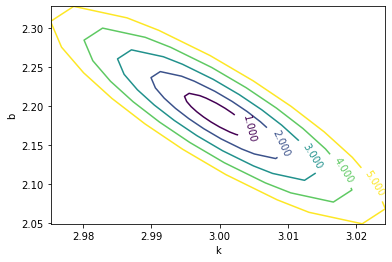

In [12]:
m.draw_mncontour('k','b', nsigma=5);  # draw five contours from sigma=1 to 5
# m.draw_contour('k','b');

We can also view the scope of those params.

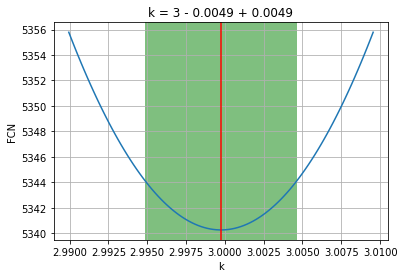

In [13]:
m.draw_profile('k');
# m.draw_profile('b');

To sum up, [Nino-hist](https://nino-hist.site) allow user to fit data by interacting with [iminuit](https://iminuit.readthedocs.io/en/latest/index.html). Sepcifically, you need to convert your histogram to numpy format, and then [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) will deal with that. With numpy arrays as the media, it's flexible. You can do whatever you want in [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) with the histograms of [Nino-hist](https://nino-hist.site). This is valuable for "Histogram" to "Analysis" in HEP analyse workflow!

## Visualization

You can use many tool for [Nino-hist](https://nino-hist.site)'s visualization, because it can be converted to numpy arrays and there are many visualization tools for numpy arrays I firmly believe. But there, our primary focus is its interation with [mplhep](https://github.com/scikit-hep/mplhep).

### mplhep Integration

Although we can use Matplotlib to visualize our histograms, it should be a better way to do the same thing in a, umm... [(Sckit-HEP)](https://scikit-hep.org/) manner. [mplhep](https://github.com/scikit-hep/mplhep) is a set of helpers for matplotlib to more easily produce plots typically needed in HEP as well as style them in way that's compatible with current collaboration requirements (ROOT).

Let's use an example to see how [mplhep](https://github.com/scikit-hep/mplhep) visualizes the histograms in [Nino-hist](https://nino-hist.site).

First, create 1-D and 2-D histograms.

In [14]:
import hist
import numpy as np
import matplotlib.pyplot as plt

data_x = np.random.normal(loc=0., scale=1., size=1_000_000)
data_y = np.random.normal(loc=0., scale=1., size=1_000_000)

h_1d = hist.Hist(
    hist.axis.Regular(500, -3, 3, name='x_1d', underflow=False, overflow=False)
)

h_1d.fill(data_x)

h_2d = hist.Hist(
    hist.axis.Regular(500, -3, 3, name='x_2d', underflow=False, overflow=False),
    hist.axis.Regular(500, -3, 3, name='y_2d', underflow=False, overflow=False)
)

h_2d.fill(data_x, data_y)

Hist(
  Regular(500, -3, 3, underflow=False, overflow=False, metadata={'name': 'x_2d', 'title': None}),
  Regular(500, -3, 3, underflow=False, overflow=False, metadata={'name': 'y_2d', 'title': None}),
  storage=Double()) # Sum: 994660.0

Then, we can plot our histogram. ([mplhep](https://github.com/scikit-hep/mplhep) is in its infancy, with a few very single features, but I'm sure there will be better interfaces later.)

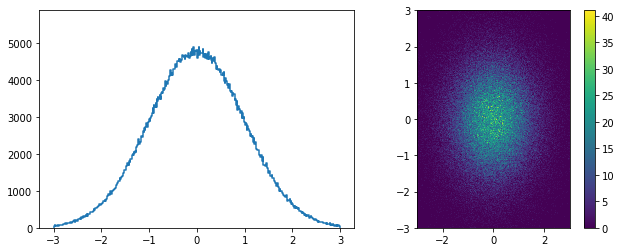

In [15]:
import mplhep

# plt.style.use(mplhep.style.LHCb)
plt.subplot(121)
w, xbins = h_1d.to_numpy()
mplhep.histplot(w.T, xbins)

plt.subplot(122)
w, xbins, ybins = h_2d.to_numpy()
mplhep.hist2dplot(w.T, xbins, ybins)

To sum up, [Nino-hist](https://nino-hist.site) allow user to visualize data by interacting with [mplhep](https://github.com/scikit-hep/mplhep). Sepcifically, you need to convert your histogram to numpy format, and then [mplhep](https://github.com/scikit-hep/mplhep) will deal with that. With numpy arrays as the media, it's flexible. You can do whatever you want in [mplhep](https://github.com/scikit-hep/mplhep) with the histograms of [Nino-hist](https://nino-hist.site). This is valuable for "Analysis" to "Visualization" in HEP analyse workflow!